# 2025 COMP90042 Project
Group 99

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*


# **1. DataSet Processing**
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### **1.1. Imports**

In [5]:
import json
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import itertools

from transformers import AutoTokenizer, AutoModel

from sentence_transformers import (
    CrossEncoder, 
    CrossEncoderTrainingArguments,
    CrossEncoderTrainer,
)
from sentence_transformers.cross_encoder.losses import BinaryCrossEntropyLoss
from datasets import Dataset

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, f1_score
from transformers import get_linear_schedule_with_warmup
import gc

### **1.2. Load Data**

In [6]:
# Load data
data_dir = "data"
train_claims_file = os.path.join(data_dir, "train-claims.json")
evidence_file = os.path.join(data_dir, "evidence.json")

# Load training data and evidence
with open(train_claims_file, 'r') as f:
    train_claims = json.load(f)
with open(evidence_file, 'r') as f:
    evidence = json.load(f)

### **1.3. Text Preprocessing**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def text_tokenizer(text):
    """Tokenize and remove stopwords"""
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Initialize TF-IDF
print("Training TF-IDF vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    tokenizer=text_tokenizer
)

# Prepare evidence data
evidence_ids = list(evidence.keys())
evidence_texts = [evidence[eid] for eid in evidence_ids]

# Train TF-IDF and transform evidence
print("Transforming evidence texts...")
evidence_vectors = tfidf_vectorizer.fit_transform(evidence_texts)

### **1.4. Find Hard Negatives**
In this section we will try to find evidences that are close to the golden evidence yet is not the correct evidence for a claim using TF-IDF.

In [ ]:
# Find hard negatives for each claim
print("Generating hard negatives...")
claim_to_hard_negatives = {}
batch_size = 100
initial_pool_size = 100  # Get top 100 most similar first
top_k = 50  # Save top 50 hard negatives per claim

for i in tqdm(range(0, len(train_claims), batch_size)):
    batch_claims = list(train_claims.items())[i:i+batch_size]

    for claim_id, claim in batch_claims:
        # Get claim TF-IDF vector
        claim_vector = tfidf_vectorizer.transform([claim['claim_text']])

        # Calculate similarities with all evidence
        similarities = cosine_similarity(claim_vector, evidence_vectors)[0]

        # Get top similar evidence
        top_indices = np.argsort(-similarities)[:initial_pool_size]  # First get top 100 most similar

        # Filter out hard negatives
        hard_negatives = []
        for idx in top_indices:
            evidence_id = evidence_ids[idx]
            if evidence_id not in claim['evidences']:  # If not in positive samples
                hard_negatives.append({
                    'evidence_id': evidence_id,
                    'similarity': float(similarities[idx])
                })
            if len(hard_negatives) >= top_k:
                break

        claim_to_hard_negatives[claim_id] = hard_negatives

# Save both full and medium difficulty results
output_file = os.path.join(data_dir, "hard_negatives.json")
with open(output_file, 'w') as f:
    json.dump(claim_to_hard_negatives, f, indent=4)

print(f"Hard negatives saved to: {output_file}")

# **2. Model Implementation**
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## **2.1. Sentence Transformer (Dual Encoder)**

### **2.1.1. Get Datasets**

In [8]:
# Set paths
data_dir = "data"
train_claims_file = os.path.join(data_dir, "train-claims.json")
dev_claims_file = os.path.join(data_dir, "dev-claims.json")
test_claims_file = os.path.join(data_dir, "test-claims-unlabelled.json")
evidence_file = os.path.join(data_dir, "evidence.json")


# Load train claims
with open(train_claims_file, 'r') as f:
    train_claims = json.load(f)
train_ids = list(train_claims.keys())
train_texts = [train_claims[claim_id]['claim_text'] for claim_id in train_ids]
claim_id_to_train_inidce = {claim_id: i for i, claim_id in enumerate(train_ids)}

print(f"Loaded {len(train_claims)} train claims.")

# Load dev claims
with open(dev_claims_file, 'r') as f:
    dev_claims = json.load(f)
dev_ids = list(dev_claims.keys())
dev_texts = [dev_claims[claim_id]['claim_text'] for claim_id in dev_ids]

print(f"Loaded {len(dev_claims)} dev claims.")

# Load test claims
with open(test_claims_file, 'r') as f:
    test_claims = json.load(f)
test_texts = [test_claims[claim_id]['claim_text'] for claim_id in test_claims.keys()]

print(f"Loaded {len(test_claims)} test claims.")

# Load evidence texts
with open(evidence_file, 'r') as f:
    evidence = json.load(f)

evidence_ids = list(evidence.keys())
evidence_texts = [evidence[claim_id] for claim_id in evidence_ids]
evidence_id_to_train_index = {claim_id: i for i, claim_id in enumerate(evidence_ids)}
print(f"Loaded {len(evidence)} evidence documents.")

Loaded 1228 train claims.
Loaded 154 dev claims.
Loaded 153 test claims.
Loaded 1208827 evidence documents.


### **2.1.2. Sentence Transformer Model Definition**

In [9]:
model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"

# define a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, max_len=512)

### **2.1.3. Contrast Loss Function**

In [10]:
def contrastive_loss(claim_embedding, pos_evidence_embeddings, neg_evidence_embeddings,  temperature=0.02):
    """Compute improved contrastive loss with lower temperature for better discrimination"""
    # Compute positive and negative similarities
    pos_sim = torch.exp(torch.matmul(claim_embedding, pos_evidence_embeddings.T) / temperature).sum()
    neg_sim = torch.exp(torch.matmul(claim_embedding, neg_evidence_embeddings.T) / temperature).sum()

    # Compute contrastive loss
    loss = -torch.log(pos_sim / (pos_sim + neg_sim))
    return loss

### **2.1.4. Embeddings and F-Scores**

In [11]:
def generate_all_embeddings(model, texts, batch_size=32):
    """Generate embeddings for all texts"""
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to(model.device)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()  # CLS token
            all_embeddings.append(embeddings)
            torch.cuda.empty_cache()
    return torch.cat(all_embeddings)

def get_test_f_scores(test_texts, test_claims, test_ids, evidence_texts, evidence_indice_to_claim_id, model, batch_size=32):
    """Get F-scores for test claims"""
    model.eval()

    # Generate test claim embeddings
    test_claim_embeddings = generate_all_embeddings(model, test_texts, batch_size=batch_size)

    # Generate evidence embeddings
    evidence_embeddings = generate_all_embeddings(model, evidence_texts, batch_size=batch_size*10)

    # Compute cosine similarities
    norm_test_claim_embeddings = F.normalize(test_claim_embeddings, p=2, dim=1)
    norm_evidence_embeddings = F.normalize(evidence_embeddings, p=2, dim=1)
    similarities = torch.matmul(norm_test_claim_embeddings, norm_evidence_embeddings.T)

    # Get top-k evidence indices for each claim
    top_k = 5
    top_k_indices = torch.topk(similarities, top_k, dim=1).indices
    top_k_indices = top_k_indices.numpy()

    # Compute F-scores
    f_scores = []
    for i, claim_id in enumerate(test_ids):
        # Get the evidence indices for the claim
        true_evidence_indices = test_claims[claim_id]["evidences"]

        # Get the predicted evidence indices
        predicted_evidence_indices = top_k_indices[i]
        predicted_evidence_indices = [evidence_indice_to_claim_id[evidence_index] for evidence_index in predicted_evidence_indices]

        # Compute precision and recall
        true_positives = len(set(true_evidence_indices) & set(predicted_evidence_indices))
        precision = true_positives / len(predicted_evidence_indices) if len(predicted_evidence_indices) > 0 else 0.0
        recall = true_positives / len(true_evidence_indices) if len(true_evidence_indices) > 0 else 0.0

        # Compute F-score
        f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f_scores.append(f_score)
    model.train()
    return np.mean(f_scores)

def compute_f_scores(true, pred):
    f_scores = []
    for claim_id in true.keys():
        # Get the evidence indices for the claim
        true_evidence_indices = true[claim_id]["evidences"]

        # Get the predicted evidence indices
        predicted_evidence_indices = pred[claim_id]["evidences"]

        # Compute precision and recall
        true_positives = len(set(true_evidence_indices) & set(predicted_evidence_indices))
        precision = true_positives / len(predicted_evidence_indices) if len(predicted_evidence_indices) > 0 else 0.0
        recall = true_positives / len(true_evidence_indices) if len(true_evidence_indices) > 0 else 0.0

        # Compute F-score
        f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f_scores.append(f_score)

    return np.mean(f_scores)

### **2.1.4. Model Training**
Alternating between TF-IDF and model-based hard negatives every two epochs

In [ ]:
# Training configuration
max_epochs = 5
batch_size = 64
learning_rate = 5e-5
test_interval = 100  # Test every 100 steps
log_interval = 20    # Log every 20 steps
update_frequency = 2 # Update hard negatives every 2 epochs
best_f1 = 0

# Initialize model
model = AutoModel.from_pretrained(model_name)
model.cuda()

# Define optimizer with learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Set random seed for reproducibility
random.seed(330)
torch.manual_seed(330)
torch.cuda.manual_seed_all(330)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load pre-computed TF-IDF hard negatives
with open(os.path.join(data_dir, "hard_negatives.json"), 'r') as f:
    tfidf_hard_negatives = json.load(f)

# Initialize hard negatives dictionary with TF-IDF results
hard_negatives_dict = tfidf_hard_negatives.copy()

step = 0
max_score = 0.0

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    random.shuffle(train_ids)

    # Alternate between TF-IDF and model-based hard negatives
    use_tfidf = (epoch % (update_frequency * 2) == 0)  # True for epochs 0, 4, 8...
    use_model = (epoch % update_frequency == 0 and not use_tfidf)  # True for epochs 2, 6...

    if use_tfidf:
        print(f"Epoch {epoch + 1}: Using TF-IDF hard negatives")
        hard_negatives_dict = tfidf_hard_negatives.copy()

    elif use_model:
        print(f"Epoch {epoch + 1}: Updating hard negatives using current model")
        model.eval()
        with torch.no_grad():
            # Filter TF-IDF hard negatives using current model
            for claim_id in tqdm(train_claims.keys(), desc="Filtering hard negatives"):
                # Get claim embedding
                claim_text = train_claims[claim_id]['claim_text']
                inputs = tokenizer(claim_text, padding=True, truncation=True, return_tensors='pt').to(model.device)
                claim_embedding = model(**inputs).last_hidden_state[:, 0, :]
                norm_claim_embedding = F.normalize(claim_embedding, p=2, dim=1)

                # Fix KeyError - check if claim_id exists in tfidf_hard_negatives
                if claim_id not in tfidf_hard_negatives:
                    hard_negatives_dict[claim_id] = []
                    continue

                # Get TF-IDF candidates
                tfidf_candidates = tfidf_hard_negatives[claim_id]
                candidate_evidence_ids = [neg['evidence_id'] for neg in tfidf_candidates]
                candidate_texts = [evidence[eid] for eid in candidate_evidence_ids]

                if not candidate_texts:  # Skip if no candidates
                    continue

                # Calculate similarities with current model
                inputs = tokenizer(
                    candidate_texts,
                    padding=True,
                    truncation=True,
                    max_length=256,
                    return_tensors='pt'
                ).to(model.device)

                evidence_embeddings = model(**inputs).last_hidden_state[:, 0, :]
                norm_evidence_embeddings = F.normalize(evidence_embeddings, p=2, dim=1)

                similarities = torch.matmul(norm_claim_embedding, norm_evidence_embeddings.T)
                similarities = similarities[0].cpu().numpy()

                # Get moderate difficulty negatives (rank 10-20)
                if len(similarities) > 20:
                    top_indices = np.argsort(similarities)[-20:-10]  # Get samples ranked 10-20
                else:
                    top_indices = np.argsort(similarities)[-5:]  # Fallback to top 5 if not enough candidates

                # Update hard negatives for this claim
                new_hard_negatives = []
                for idx in top_indices:
                    evidence_id = candidate_evidence_ids[idx]
                    if evidence_id not in train_claims[claim_id]['evidences']:
                        new_hard_negatives.append({
                            'evidence_id': evidence_id,
                            'similarity': float(similarities[idx])
                        })

                hard_negatives_dict[claim_id] = new_hard_negatives

        model.train()

    # Training loop
    for i in range(0, len(train_ids), batch_size):
        step += 1
        print(f"Step {step}")
        batch_ids = train_ids[i:i + batch_size]
        batch_claims = [train_claims[claim_id] for claim_id in batch_ids]
        batch_indices = [claim_id_to_train_inidce[claim_id] for claim_id in batch_ids]

        # Get evidence indices including current hard negatives
        evidence_indices = []
        pos_evidence_positive_indices = []
        for claim_id, claim in zip(batch_ids, batch_claims):
            # Add positive samples
            positive_indices = []
            for evidence_id in claim["evidences"][:2]:  # Use at most 2 positive samples
                evidence_idx = evidence_id_to_train_index[evidence_id]
                if evidence_idx not in evidence_indices:
                    evidence_indices.append(evidence_idx)
                positive_indices.append(len(evidence_indices) - 1)

            # Fix KeyError - check if claim_id exists in hard_negatives_dict
            if claim_id in hard_negatives_dict:
                hard_negs = hard_negatives_dict[claim_id][:3]  # Use top 3 hard negatives
                for neg in hard_negs:
                    neg_idx = evidence_id_to_train_index[neg['evidence_id']]
                    if neg_idx not in evidence_indices:
                        evidence_indices.append(neg_idx)

            pos_evidence_positive_indices.append(positive_indices)

        # Get claim embeddings
        claim_texts = [train_texts[i] for i in batch_indices]
        model_inputs = tokenizer(claim_texts, padding=True, truncation=True, return_tensors='pt').to(model.device)
        claim_embeddings = model(**model_inputs).last_hidden_state[:, 0, :]
        norm_claim_embeddings = F.normalize(claim_embeddings, p=2, dim=1)

        # Get evidence embeddings
        cur_evidence_indices = [evidence_texts[evidence_indice] for evidence_indice in evidence_indices]
        evidence_model_inputs = tokenizer(
            cur_evidence_indices,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors='pt'
        ).to(model.device)

        evidence_embeddings = model(**evidence_model_inputs).last_hidden_state[:, 0, :]
        norm_evidence_embeddings = F.normalize(evidence_embeddings, p=2, dim=1)

        # Calculate loss
        loss = []
        for i, claim_embedding in enumerate(norm_claim_embeddings):
            pos_evidence_embeddings = norm_evidence_embeddings[torch.tensor(pos_evidence_positive_indices[i])]
            neg_evidence_embeddings = norm_evidence_embeddings[torch.tensor([j for j in range(len(evidence_indices))
                                                               if j not in pos_evidence_positive_indices[i]])]
            loss.append(contrastive_loss(claim_embedding, pos_evidence_embeddings, neg_evidence_embeddings))
        loss = torch.mean(torch.stack(loss))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clear cache
        del evidence_embeddings, norm_evidence_embeddings
        torch.cuda.empty_cache()

        if step % log_interval == 0:
            print(f"Loss: {loss.item()}")

        if step % test_interval == 0:
            # Evaluate on dev set
            f_score = get_test_f_scores(dev_texts, dev_claims, dev_ids, evidence_texts, evidence_ids, model, batch_size=batch_size)
            print(f"F-score on dev set: {f_score}")
            # Save model
            torch.save(model.state_dict(), f"model_epoch_{epoch + 1}_step_{step}.pth")
            if f_score > max_score:
                max_score = f_score
                print(f"New best F-score: {max_score}")
                torch.save(model.state_dict(), "best_model.pth")

    # Update learning rate
    scheduler.step()

In [ ]:
# Re-initialise best model from saved state
model = AutoModel.from_pretrained(model_name)
model.load_state_dict(torch.load("best_model.pth"))
model.cuda()

## **2.2. Cross Encoder**

### **2.2.1. Evidence Cross Check Function**

In [16]:
def evidence_crosscheck(claim_text, candidate_evidence_ids, candidate_texts, model):
    '''Custom implementation of a final clustering step minimising sentence entropy in
    retrieved evidences.'''

    MAX_CLUSTER_SIZE = 5

    # Create input pairs including claim text (-1 is claim text)
    idxs = candidate_evidence_ids + ['-1']
    pair_texts = {}
    pairs = [list(tup) for tup in itertools.combinations(idxs, 2)]
    for p in pairs:
        if '-1' in p:
            text_pair = (candidate_texts[p[0]], claim_text)
        else:
            text_pair = (candidate_texts[p[0]], candidate_texts[p[1]])
        pair_texts[tuple(p)] = text_pair

    scores = model.predict(list(pair_texts.values()))

    pair_scores = {}
    keys = list(pair_texts.keys())
    for i in range(len(scores)):
        pair_scores[keys[i]] = scores[i]

    # Generate all combinations of evidence pairs 1..5
    clusters = []
    for i in range(2, MAX_CLUSTER_SIZE + 2):
        clusters += list(itertools.combinations(idxs, i))

    # Score each cluster and save the best
    best_score = 0
    best_cluster = None
    cluster_scores = {}
    for cluster in clusters:
        sims = 0
        cluster_pairs = list(itertools.combinations(cluster, 2))
        for cluster_pair in cluster_pairs:
            sims += pair_scores[cluster_pair]
        score = sims/len(cluster)
        cluster_scores[cluster] = score

        if score >= best_score:
            best_score = score
            best_cluster = cluster

    if best_cluster is None:
        best_cluster = cluster

    # Remove claim text from cluster
    if '-1' in best_cluster:
        best_cluster = [cs for cs in best_cluster if cs != '-1']

    return list(best_cluster)

### **2.2.2. Initial Ranking**

In [17]:
def generate_top_k_evidence(model, claim_texts, evidence_texts, evidence_ids, top_k=100, batch_size=32):
    """Generate top-k evidence for each claim using the model."""
    model.eval()

    claim_embeddings = generate_all_embeddings(model, claim_texts, batch_size=batch_size)
    evidence_embeddings = generate_all_embeddings(model, evidence_texts, batch_size=batch_size*10)

    # Normalize embeddings
    norm_claim_embeddings = F.normalize(claim_embeddings, p=2, dim=1)
    norm_evidence_embeddings = F.normalize(evidence_embeddings, p=2, dim=1)

    # Compute similarities and sort
    similarities = torch.matmul(norm_claim_embeddings, norm_evidence_embeddings.T)
    top_k_indices = torch.topk(similarities, top_k, dim=1).indices.numpy()

    return top_k_indices

### **2.2.3. Training Cross Encoder**

In [19]:
def train_cross_encoder(st_model, train_texts, evidence_texts, evidence_ids, evidence):

    top_k_indices = generate_top_k_evidence(st_model, train_texts, evidence_texts, evidence_ids)

    print(f"Generated top-k evidence from sentence transformer!")
    print(f"Creating sample pairs...")

    # Create dataset with positive and negative sample pairs for cross-encoder training
    claims = []
    pos_neg = []
    labels = []
    for i, claim_id in tqdm(enumerate(train_ids)):
        claim_text = train_claims[claim_id]['claim_text']
        true_evidence_ids = train_claims[claim_id]['evidences']

        # First stage candidates
        candidate_indices = top_k_indices[i]

        # hard negative samples
        for idx in candidate_indices:
            if evidence_ids[idx] not in true_evidence_ids:
                claims.append(claim_text)
                pos_neg.append(evidence_texts[idx])
                labels.append(0)  

        # positive samples
        for true_evidence_id in true_evidence_ids:
            claims.append(claim_text)
            pos_neg.append(evidence[true_evidence_id])
            labels.append(1)  

    data = {
        "claims": claims,
        "pos_neg": pos_neg,
        "label": labels
    }

    ce_dataset = Dataset.from_dict(data)
    ce_split_dataset = ce_dataset.train_test_split(test_size=0.1, seed=42)
    ce_train_ds = ce_split_dataset["train"]
    ce_eval_ds = ce_split_dataset["test"]

    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')
    ce_loss = BinaryCrossEntropyLoss(cross_encoder)

    args = CrossEncoderTrainingArguments(
        # Required parameter:
        output_dir="output",
        # Optional training parameters:
        num_train_epochs=1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        warmup_ratio=0.1,
        fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
        bf16=False,  # Set to True if you have a GPU that supports BF16
        # Optional tracking/debugging parameters:
        eval_strategy="steps",
        eval_steps=250,
        save_strategy="steps",
        save_steps=250,
        save_total_limit=2,
        logging_steps=250,
        run_name="cross-encoder-training",
        load_best_model_at_end=True,
        greater_is_better=True,
    )

    ce_trainer = CrossEncoderTrainer(
        model=cross_encoder,
        args=args,
        train_dataset=ce_train_ds,
        eval_dataset=ce_eval_ds,
        loss=ce_loss,
    )

    print(f"Training cross-encoder...")

    ce_trainer.train()
    ce_trainer.save_model("best_cross_encoder")

train_cross_encoder(model, train_texts, evidence_texts, evidence_ids, evidence)

100%|██████████| 3778/3778 [06:44<00:00,  9.34it/s]


Generated top-k evidence from sentence transformer!
Creating sample pairs...


1228it [00:00, 17365.73it/s]


Training cross-encoder...


Step,Training Loss,Validation Loss
250,0.203600,0.195839
500,0.160700,0.154908
750,0.148500,0.148521
1000,0.135400,0.147799
1250,0.129200,0.139627
1500,0.138700,0.136834
1750,0.140400,0.138507
2000,0.155800,0.135020
2250,0.134900,0.135905
2500,0.136900,0.136668


In [20]:
# Load the trained cross-encoder model
cross_encoder = CrossEncoder('best_cross_encoder')

### **2.2.4. Cross-encoder Reranking and Evaluation**

In [21]:
# Reranking function
def rerank_evidences(claim, candidate_evidence_ids, candidate_texts, model, top_k=10):
    """Rerank candidate evidences using a cross-encoder model"""

    # Create input pairs: (claim, evidence)
    paired_texts = []
    for evidence_text in candidate_texts:
        paired_texts.append((claim, evidence_text))

    scores = model.predict(paired_texts)

    # Rerank based on scores
    reranked_indices = np.argsort(-scores)[:top_k]
    reranked_evidence_ids = [candidate_evidence_ids[i] for i in reranked_indices]

    return reranked_evidence_ids

# Evaluation function to calculate F-scores
def evaluate_with_reranking(test_texts, test_claims, test_ids, evidence_texts, evidence_ids,
                           initial_model, cross_encoder,
                           batch_size=16, initial_k=50, final_k=5):
    """Evaluate F-score of the two-stage retrieval system"""
    initial_model.eval()

    # Generate test claim embeddings
    test_claims_embeddings = generate_all_embeddings(initial_model, test_texts, batch_size=batch_size)

    # Generate evidence embeddings
    test_evidence_embeddings = generate_all_embeddings(initial_model, evidence_texts, batch_size=batch_size*10)

    # Normalize embeddings
    norm_test_claim_embeddings = F.normalize(test_claims_embeddings, p=2, dim=1)
    norm_evidence_embeddings = F.normalize(test_evidence_embeddings, p=2, dim=1)

    # First stage: compute similarities and get initial candidates
    similarities = torch.matmul(norm_test_claim_embeddings, norm_evidence_embeddings.T)
    top_k_initial = torch.topk(similarities, initial_k, dim=1).indices.numpy()

    # Calculate F-scores
    f_scores = []
    res = test_claims.copy()
    for i, claim_id in enumerate(test_ids):
        # Get true evidence
        true_evidence_ids = test_claims[claim_id]["evidences"]

        # Get claim text
        claim_text = test_claims[claim_id]["claim_text"]

        # Get first-stage candidates
        candidate_indices = top_k_initial[i]
        candidate_evidence_ids = [evidence_ids[idx] for idx in candidate_indices]
        candidate_texts = [evidence_texts[idx] for idx in candidate_indices]

        # Rerank using cross-encoder
        reranked_evidence_ids = rerank_evidences(
            claim_text,
            candidate_evidence_ids,
            candidate_texts,
            cross_encoder,
            top_k=final_k
        )

        res[claim_id]['evidences'] = reranked_evidence_ids

        # Calculate precision and recall
        true_positives = len(set(true_evidence_ids) & set(reranked_evidence_ids))
        precision = true_positives / len(reranked_evidence_ids) if len(reranked_evidence_ids) > 0 else 0.0
        recall = true_positives / len(true_evidence_ids) if len(true_evidence_ids) > 0 else 0.0

        # Calculate F-score
        f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f_scores.append(f_score)

        # Print results for each sample
        # print(f"Claim {i+1}/{len(test_ids)}: F-score = {f_score:.4f}, P = {precision:.4f}, R = {recall:.4f}")

    return np.mean(f_scores), res

### **2.2.5. Generating Evidence Clusters**

In [22]:
# Generate minimised entropy predictions
def generate_crosschecked_evidences(original_guesses, evidence, cross_encoder):
    minimal_preds = {}
    for claim in tqdm(original_guesses.keys()):
        evidence_text_dict = {}
        for eid in original_guesses[claim]['evidences']:
            evidence_text_dict[eid] = evidence[eid]

        res = evidence_crosscheck(
            original_guesses[claim]['claim_text'],
            original_guesses[claim]['evidences'],
            evidence_text_dict,
            cross_encoder
        )

        minimal_preds[claim] = {
            'claim_text': original_guesses[claim]['claim_text'],
            'evidences': res
        }

    return minimal_preds

### **2.2.6 Cross Encoder Evaluation** 

In [23]:
# Evaluate on dev set
print("Evaluating on dev set...")

# First evaluate baseline without reranking
print("Baseline without reranking:")
baseline_f1 = get_test_f_scores(dev_texts, dev_claims, dev_ids, evidence_texts, evidence_ids, model, batch_size=64)
print(f"Baseline F-score on dev set: {baseline_f1:.4f}")

# Then evaluate with reranking
print("\nWith reranking:")
reranked_f1, rerank_res = evaluate_with_reranking (
    dev_texts, dev_claims, dev_ids, evidence_texts, evidence_ids,
    model, cross_encoder,
    batch_size=32, initial_k=50, final_k=5)
print(f"Reranked F-score on dev set: {reranked_f1:.4f}")
print(f"Improvement over baseline: {(reranked_f1 - baseline_f1) * 100:.2f}%")

# Then evaluate with evidence cross-checking
print("\n With evidence cross-checking:")
minimal_preds = generate_crosschecked_evidences (
    rerank_res,
    evidence,
    cross_encoder
)
cross_check_f1 = compute_f_scores(dev_claims, minimal_preds)
print(f"Evidence cross-checked F-score on dev set: {cross_check_f1:.4f}")
print(f"Improvement over reranked: {(cross_check_f1 - reranked_f1) * 100:.2f}%")

Evaluating on dev set...
Baseline without reranking:


100%|██████████| 1889/1889 [08:40<00:00,  3.63it/s]  


Baseline F-score on dev set: 0.1633

With reranking:


100%|██████████| 3778/3778 [06:37<00:00,  9.51it/s]


Reranked F-score on dev set: 0.2092
Improvement over baseline: 4.59%

 With evidence cross-checking:


100%|██████████| 154/154 [00:01<00:00, 131.90it/s]

Evidence cross-checked F-score on dev set: 0.6825
Improvement over reranked: 47.33%


### **2.3 Generate Test Evidence Retrieval**

In [24]:
# Function to generate test predictions with reranking
def generate_test_predictions_with_reranking(test_texts, test_claims, test_ids, evidence_texts, evidence_ids,
                                           initial_model, cross_encoder,
                                           batch_size=16, initial_k=50, final_k=5):
    """Generate test predictions with two-stage retrieval (retrieval + reranking)"""
    initial_model.eval()

    # Generate test claim embeddings
    test_claims_embeddings = generate_all_embeddings(initial_model, test_texts, batch_size=batch_size)

    # Generate evidence embeddings
    test_evidence_embeddings = generate_all_embeddings(initial_model, evidence_texts, batch_size=batch_size*10)

    # Normalize embeddings
    norm_test_claim_embeddings = F.normalize(test_claims_embeddings, p=2, dim=1)
    norm_evidence_embeddings = F.normalize(test_evidence_embeddings, p=2, dim=1)

    # First stage: compute similarities and get initial candidates
    similarities = torch.matmul(norm_test_claim_embeddings, norm_evidence_embeddings.T)
    top_k_initial = torch.topk(similarities, initial_k, dim=1).indices.numpy()

    # Second stage: rerank and save results
    results = test_claims.copy()
    for i, claim_id in enumerate(test_ids):
        # Get claim text
        claim_text = test_claims[claim_id]['claim_text']

        # Get first-stage candidates
        candidate_indices = top_k_initial[i]
        candidate_evidence_ids = [evidence_ids[idx] for idx in candidate_indices]
        candidate_texts = [evidence_texts[idx] for idx in candidate_indices]

        # Rerank with cross-encoder
        reranked_evidence_ids = rerank_evidences(
            claim_text,
            candidate_evidence_ids,
            candidate_texts,
            cross_encoder,
            top_k=final_k
        )

        # Store final results
        results[claim_id]['evidences'] = reranked_evidence_ids

    return results

In [25]:
# Generate test set predictions
print("\nGenerating test set predictions...")
test_claims_ids = list(test_claims.keys())
rerank_res = generate_test_predictions_with_reranking(
    test_texts, test_claims, test_claims_ids, evidence_texts, evidence_ids,
    model, cross_encoder,
    batch_size=32, initial_k=50, final_k=5
)
minimal_preds = generate_crosschecked_evidences(
    rerank_res,
    evidence,
    cross_encoder
)

# Save results
output_file = os.path.join(data_dir, "test_claims_retrieved_reranked.json")
with open(output_file, 'w') as f:
    json.dump(rerank_res, f, indent=4)
print(f"Results saved to {output_file}")

output_file = os.path.join(data_dir, "test_claims_retrieved_minimised.json")
with open(output_file, 'w') as f:
    json.dump(minimal_preds, f, indent=4)
print(f"Results saved to {output_file}")


Generating test set predictions...


100%|██████████| 153/153 [00:01<00:00, 139.81it/s]

Results saved to data\test_claims_retrieved_reranked.json
Results saved to data\test_claims_retrieved_minimised.json


## **2.4. Claim Classification**

### **2.4.1. Re-Initialise Datatsets**

In [26]:
# Set paths
data_dir = "data"
train_claims_file = os.path.join(data_dir, "train-claims.json")
dev_claims_file = os.path.join(data_dir, "dev-claims.json")
test_claims_file = os.path.join(data_dir, "test_claims_retrieved_reranked.json")
evidence_file = os.path.join(data_dir, "evidence.json")

sep_token = "[SEP]"
cls_token = "[CLS]"

id2labels = ["SUPPORTS", "NOT_ENOUGH_INFO", "REFUTES", "DISPUTED"]
labels2id = {"SUPPORTS": 0, "NOT_ENOUGH_INFO": 1, "REFUTES": 2, "DISPUTED": 3}

# Load evidences
with open(evidence_file, 'r') as f:
    evidences = json.load(f)
print(f"Loaded {len(evidences)} evidence documents.")

# Load train claims
with open(train_claims_file, 'r') as f:
    train_claims = json.load(f)

train_data = []
for train_id in train_claims.keys():
    claim = train_claims[train_id]['claim_text']
    cur_evidences = train_claims[train_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    train_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    train_data.append({
        'input': train_input,
        'label': labels2id[train_claims[train_id]['claim_label']],
    })

print(f"Loaded {len(train_data)} train items.")

# Load dev claims
with open(dev_claims_file, 'r') as f:
    dev_claims = json.load(f)

dev_data = []
for dev_id in dev_claims.keys():
    claim = dev_claims[dev_id]['claim_text']
    cur_evidences = dev_claims[dev_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    dev_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    dev_data.append({
        'input': dev_input,
        'label': labels2id[dev_claims[dev_id]['claim_label']],
    })

print(f"Loaded {len(dev_data)} dev items.")

# Load test claims
with open(test_claims_file, 'r') as f:
    test_claims = json.load(f)

test_data = []
test_ids = list(test_claims.keys())
for test_id in test_ids:
    claim = test_claims[test_id]['claim_text']
    cur_evidences = test_claims[test_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    test_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    test_data.append({
        'input': test_input,
        'label': -1,  # Placeholder for test data labels
    })


Loaded 1208827 evidence documents.
Loaded 1228 train items.
Loaded 154 dev items.


### **2.4.2. Initialise Models**

In [27]:
seed = 330
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2labels))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Rasindu\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rasindu\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **2.4.3. Initialise Dataset Classes**

In [28]:
# DataLoader for train, and test data
from torch.utils.data import Dataset, DataLoader

class ClaimsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Better processing method: using model's standard format
        if 'claim_text' in item and 'evidence_texts' in item:
            # Assuming each data item contains separate claim and evidences
            claim = item['claim_text']
            evidences = item['evidence_texts']
            evidence_text = " ".join(evidences[:3])  # Limit number of evidences to avoid truncation

            inputs = self.tokenizer(
                claim,                 # Claim as the first text
                evidence_text,         # Evidence as the second text
                padding='max_length',
                truncation='longest_first',
                max_length=self.max_length,
                return_tensors="pt"
            )
        else:
            # Compatible with existing input format
            inputs = self.tokenizer(
                item['input'],
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )

        label = torch.tensor(item['label'])

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': label
        }

    def collate_fn(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [29]:
batch_size = 32

train_dataset = ClaimsDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

dev_dataset = ClaimsDataset(dev_data, tokenizer)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=dev_dataset.collate_fn)

test_dataset = ClaimsDataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

### **2.4.4. Label Smoothing Loss**

In [30]:
# Define Label Smoothing Loss class
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # Create smoothed label distribution
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def validate_model_with_exposure_mitigation(model, exposure_mitigator, dataloader, device, criterion=None):
    model.eval()
    exposure_mitigator.training = False
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"[Validating]")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass using exposure mitigator
            logits = exposure_mitigator.forward_with_scheduled_sampling(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Use label smoothing loss or default cross entropy
            if criterion is not None:
                loss = criterion(logits, labels)
            else:
                loss = F.cross_entropy(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    model.train()  # Set model back to training mode
    return avg_loss, accuracy

### **2.4.5. Exposure Bias for Scheduled Sampling**

In [31]:
# Implementation of scheduled sampling to mitigate exposure bias
class ExposureBiasMitigator:
    def __init__(self, model, device, num_labels, decay_rate=0.01):
        """
        Args:
            model: The classification model
            device: The device to run on
            num_labels: Number of classification labels
            decay_rate: Rate at which to decrease teacher forcing probability
        """
        self.model = model
        self.device = device
        self.num_labels = num_labels
        self.decay_rate = decay_rate
        self.teacher_forcing_prob = 1.0

    def update_teacher_forcing_prob(self, epoch):
        """Decrease teacher forcing probability as training progresses"""
        self.teacher_forcing_prob = max(0.0, 1.0 - self.decay_rate * epoch)
        return self.teacher_forcing_prob

    def forward_with_scheduled_sampling(self, input_ids, attention_mask, labels):
        """Forward pass with scheduled sampling to mitigate exposure bias"""
        # Initial forward pass with all real inputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply scheduled sampling for a second forward pass
        if self.training and random.random() > self.teacher_forcing_prob:
            # Generate pseudo-labels based on model prediction
            with torch.no_grad():
                pseudo_probs = F.softmax(logits, dim=-1)
                # Sample from the distribution
                pseudo_labels = torch.multinomial(pseudo_probs, 1).squeeze(-1)

            # Create token type ids based on pseudo-labels
            # This simulates the model being conditioned on its own predictions
            token_type_ids = torch.zeros_like(input_ids)
            for i, label in enumerate(pseudo_labels):
                # Set token type based on predicted class
                token_type_ids[i, :] = label.item()

            # Second forward pass with token type ids from predicted labels
            if hasattr(self.model, 'token_type_embeddings'):
                # If model supports token type embeddings
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )
                logits = outputs.logits

        return logits

### **2.4.6. Homogeneous Ensemble Run for Different Seeds**

In [32]:
# Memory-efficient implementation of model ensemble techniques
class EnsembleClassifier:
    """Memory-efficient implementation of homogeneous ensemble for fact verification"""
    def __init__(self, model_names, device, num_labels=3):
        """
        Args:
            model_names: List of model names to use in ensemble
            device: Device to run models on
            num_labels: Number of classification labels
        """
        self.model_names = model_names
        self.device = device
        self.num_labels = num_labels
        self.tokenizers = {}
        self.models = {}

    def _load_model(self, model_name):
        """Dynamically load and cache models to save memory"""
        if model_name in self.models:
            return self.models[model_name]

        # Clean memory before loading a new model
        gc.collect()
        torch.cuda.empty_cache()

        print(f"Loading model: {model_name}")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=self.num_labels
        ).to(self.device)

        # Cache for later use
        self.models[model_name] = model
        return model

    def _unload_models(self):
        """Unload all models to free memory"""
        for key in list(self.models.keys()):
            del self.models[key]
        self.models = {}
        gc.collect()
        torch.cuda.empty_cache()

    def homogeneous_ensemble(self, dataloader, model_name, model_checkpoint, num_runs=3):
        """Homogeneous ensemble - Train model multiple times with different seeds"""
        all_predictions = []
        all_logits = []

        # Use same model but with different random initializations
        base_model = self._load_model(model_name)

        for run in range(num_runs):
            print(f"Run {run+1}/{num_runs}")

            # Set different seed for each run
            torch.manual_seed(330 + run)
            torch.cuda.manual_seed_all(330 + run)

            # Load the model checkpoint but with different initialization for some layers
            model = self._load_model(model_name)

            # Optionally load some pre-trained weights
            if model_checkpoint:
                model.load_state_dict(torch.load(model_checkpoint), strict=False)

            # Get predictions for this run
            model.eval()
            run_logits = []

            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"Evaluating run {run+1}"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    batch_logits = outputs.logits
                    run_logits.append(batch_logits)

            # Concat all batch logits
            run_logits = torch.cat(run_logits, dim=0).cpu()
            all_logits.append(run_logits)

            # Free memory
            del model
            gc.collect()
            torch.cuda.empty_cache()

        # Combine predictions from all runs (average logits)
        avg_logits = torch.stack(all_logits).mean(dim=0)
        _, predictions = torch.max(avg_logits, dim=1)

        return predictions.numpy()

### **2.4.7. Model Training**

In [33]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Initialize exposure bias mitigator
exposure_mitigator = ExposureBiasMitigator(model, device, len(id2labels), decay_rate=0.05)

# Define optimizer and learning rate
learning_rate = 1e-5
# Define number of epochs
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Add learning rate scheduler to improve training stability
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,  # Warmup steps
    num_training_steps=total_steps
)



# Validation interval
val_interval = 100

# Logging interval
log_interval = 20

# Define label smoothing loss function
criterion = LabelSmoothingLoss(classes=len(id2labels), smoothing=0.1)

# Training loop
best_val_acc = 0.0
best_model_state = None

step = 0
model.train()
# Training phase

for epoch in range(num_epochs):

    # if step > 120:
    #         break
    # Update teacher forcing probability
    tf_prob = exposure_mitigator.update_teacher_forcing_prob(epoch)
    print(f"Epoch {epoch+1}/{num_epochs} - Teacher forcing probability: {tf_prob:.4f}")

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for batch in progress_bar:
        # if step > 120:
        #     break

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # logits = outputs.logits
        exposure_mitigator.training = True
        logits = exposure_mitigator.forward_with_scheduled_sampling(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Use label smoothing loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()


         # Gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item(), "lr": scheduler.get_last_lr()[0]})
        step += 1

        if step % log_interval == 0:
            print(f"Step {step}: Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.7f}")

        # Validation phase
        if step % val_interval == 0:
            # Set exposure mitigator to eval mode
            exposure_mitigator.training = False
            val_loss, val_accuracy = validate_model_with_exposure_mitigation(
                model, exposure_mitigator, dev_dataloader, device, criterion
            )
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Save best model based on validation F1
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                print(f"New best model found! Validation Accuracy: {val_accuracy:.4f}")
                # Save the model state
                torch.save(model.state_dict(), "best_classification_model.pth")
                # Early stopping if accuracy reaches high threshold
                if val_accuracy > 0.75:
                    print(f"Reached high accuracy ({val_accuracy:.4f}). Early stopping.")
                    break

print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")


Using device: cuda
Epoch 1/20 - Teacher forcing probability: 1.0000


Epoch 1/20 [Training]:  51%|█████▏    | 20/39 [00:08<00:08,  2.35it/s, loss=1.39, lr=2e-6]  

Step 20: Loss: 1.3904, LR: 0.0000020


Epoch 1/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.38it/s, loss=1.33, lr=3.9e-6]


Epoch 2/20 - Teacher forcing probability: 0.9500


Epoch 2/20 [Training]:   3%|▎         | 1/39 [00:00<00:15,  2.40it/s, loss=1.33, lr=4e-6]

Step 40: Loss: 1.3292, LR: 0.0000040


Epoch 2/20 [Training]:  54%|█████▍    | 21/39 [00:08<00:07,  2.42it/s, loss=1.27, lr=6e-6]  

Step 60: Loss: 1.2702, LR: 0.0000060


Epoch 2/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.45it/s, loss=1.18, lr=7.8e-6]


Epoch 3/20 - Teacher forcing probability: 0.9000


Epoch 3/20 [Training]:   5%|▌         | 2/39 [00:00<00:15,  2.39it/s, loss=1.25, lr=8e-6]  

Step 80: Loss: 1.2497, LR: 0.0000080


Epoch 3/20 [Training]:  54%|█████▍    | 21/39 [00:09<00:07,  2.38it/s, loss=1.13, lr=1e-5]  

Step 100: Loss: 1.1303, LR: 0.0000100


[Validating]: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


Validation Loss: 1.2314, Validation Accuracy: 0.5065
New best model found! Validation Accuracy: 0.5065


Epoch 3/20 [Training]: 100%|██████████| 39/39 [00:17<00:00,  2.29it/s, loss=1.09, lr=9.75e-6]


Epoch 4/20 - Teacher forcing probability: 0.8500


Epoch 4/20 [Training]:   8%|▊         | 3/39 [00:01<00:15,  2.38it/s, loss=1.04, lr=9.71e-6]

Step 120: Loss: 1.0444, LR: 0.0000097


Epoch 4/20 [Training]:  59%|█████▉    | 23/39 [00:09<00:06,  2.39it/s, loss=0.991, lr=9.41e-6]

Step 140: Loss: 0.9907, LR: 0.0000094


Epoch 4/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s, loss=1.04, lr=9.18e-6] 


Epoch 5/20 - Teacher forcing probability: 0.8000


Epoch 5/20 [Training]:  10%|█         | 4/39 [00:01<00:14,  2.38it/s, loss=0.924, lr=9.12e-6]

Step 160: Loss: 0.9235, LR: 0.0000091


Epoch 5/20 [Training]:  62%|██████▏   | 24/39 [00:10<00:06,  2.35it/s, loss=0.901, lr=8.82e-6]

Step 180: Loss: 0.9010, LR: 0.0000088


Epoch 5/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.39it/s, loss=0.968, lr=8.6e-6] 


Epoch 6/20 - Teacher forcing probability: 0.7500


Epoch 6/20 [Training]:  10%|█         | 4/39 [00:02<00:14,  2.41it/s, loss=0.964, lr=8.53e-6]

Step 200: Loss: 0.9636, LR: 0.0000085


[Validating]: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


Validation Loss: 1.0334, Validation Accuracy: 0.6429
New best model found! Validation Accuracy: 0.6429


Epoch 6/20 [Training]:  64%|██████▍   | 25/39 [00:11<00:06,  2.32it/s, loss=0.882, lr=8.24e-6]

Step 220: Loss: 0.8815, LR: 0.0000082


Epoch 6/20 [Training]: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s, loss=1.26, lr=8.03e-6] 


Epoch 7/20 - Teacher forcing probability: 0.7000


Epoch 7/20 [Training]:  15%|█▌        | 6/39 [00:02<00:14,  2.34it/s, loss=0.829, lr=7.94e-6]

Step 240: Loss: 0.8286, LR: 0.0000079


Epoch 7/20 [Training]:  67%|██████▋   | 26/39 [00:10<00:05,  2.42it/s, loss=0.816, lr=7.65e-6]

Step 260: Loss: 0.8161, LR: 0.0000076


Epoch 7/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s, loss=0.858, lr=7.46e-6]


Epoch 8/20 - Teacher forcing probability: 0.6500


Epoch 8/20 [Training]:  18%|█▊        | 7/39 [00:02<00:13,  2.42it/s, loss=0.81, lr=7.35e-6] 

Step 280: Loss: 0.8103, LR: 0.0000074


Epoch 8/20 [Training]:  67%|██████▋   | 26/39 [00:11<00:05,  2.42it/s, loss=0.685, lr=7.06e-6]

Step 300: Loss: 0.6853, LR: 0.0000071


[Validating]: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]


Validation Loss: 0.9843, Validation Accuracy: 0.6753
New best model found! Validation Accuracy: 0.6753


Epoch 8/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.32it/s, loss=0.97, lr=6.88e-6] 


Epoch 9/20 - Teacher forcing probability: 0.6000


Epoch 9/20 [Training]:  21%|██        | 8/39 [00:03<00:12,  2.43it/s, loss=0.771, lr=6.76e-6]

Step 320: Loss: 0.7711, LR: 0.0000068


Epoch 9/20 [Training]:  72%|███████▏  | 28/39 [00:11<00:04,  2.43it/s, loss=0.807, lr=6.47e-6]

Step 340: Loss: 0.8069, LR: 0.0000065


Epoch 9/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.46it/s, loss=0.717, lr=6.31e-6]


Epoch 10/20 - Teacher forcing probability: 0.5500


Epoch 10/20 [Training]:  23%|██▎       | 9/39 [00:03<00:12,  2.41it/s, loss=0.648, lr=6.18e-6]

Step 360: Loss: 0.6479, LR: 0.0000062


Epoch 10/20 [Training]:  74%|███████▍  | 29/39 [00:12<00:04,  2.40it/s, loss=0.825, lr=5.88e-6]

Step 380: Loss: 0.8251, LR: 0.0000059


Epoch 10/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.44it/s, loss=0.727, lr=5.74e-6]


Epoch 11/20 - Teacher forcing probability: 0.5000


Epoch 11/20 [Training]:  23%|██▎       | 9/39 [00:04<00:12,  2.39it/s, loss=0.807, lr=5.59e-6]

Step 400: Loss: 0.8073, LR: 0.0000056


[Validating]: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


Validation Loss: 0.9976, Validation Accuracy: 0.6948
New best model found! Validation Accuracy: 0.6948


Epoch 11/20 [Training]:  77%|███████▋  | 30/39 [00:13<00:03,  2.40it/s, loss=0.662, lr=5.29e-6]

Step 420: Loss: 0.6623, LR: 0.0000053


Epoch 11/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.30it/s, loss=0.757, lr=5.16e-6]


Epoch 12/20 - Teacher forcing probability: 0.4500


Epoch 12/20 [Training]:  28%|██▊       | 11/39 [00:04<00:11,  2.44it/s, loss=0.649, lr=5e-6]   

Step 440: Loss: 0.6491, LR: 0.0000050


Epoch 12/20 [Training]:  79%|███████▉  | 31/39 [00:12<00:03,  2.42it/s, loss=0.627, lr=4.71e-6]

Step 460: Loss: 0.6272, LR: 0.0000047


Epoch 12/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.46it/s, loss=0.984, lr=4.59e-6]


Epoch 13/20 - Teacher forcing probability: 0.4000


Epoch 13/20 [Training]:  31%|███       | 12/39 [00:05<00:11,  2.38it/s, loss=0.777, lr=4.41e-6]

Step 480: Loss: 0.7773, LR: 0.0000044


Epoch 13/20 [Training]:  79%|███████▉  | 31/39 [00:13<00:03,  2.40it/s, loss=0.701, lr=4.12e-6]

Step 500: Loss: 0.7006, LR: 0.0000041


Epoch 13/20 [Training]:  82%|████████▏ | 32/39 [00:14<00:04,  1.61it/s, loss=0.701, lr=4.12e-6]

Validation Loss: 1.0125, Validation Accuracy: 0.6818


Epoch 13/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.33it/s, loss=0.757, lr=4.01e-6]


Epoch 14/20 - Teacher forcing probability: 0.3500


Epoch 14/20 [Training]:  33%|███▎      | 13/39 [00:05<00:10,  2.41it/s, loss=0.691, lr=3.82e-6]

Step 520: Loss: 0.6915, LR: 0.0000038


Epoch 14/20 [Training]:  85%|████████▍ | 33/39 [00:13<00:02,  2.42it/s, loss=0.771, lr=3.53e-6]

Step 540: Loss: 0.7710, LR: 0.0000035


Epoch 14/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.45it/s, loss=0.825, lr=3.44e-6]


Epoch 15/20 - Teacher forcing probability: 0.3000


Epoch 15/20 [Training]:  36%|███▌      | 14/39 [00:05<00:10,  2.40it/s, loss=0.651, lr=3.24e-6]

Step 560: Loss: 0.6511, LR: 0.0000032


Epoch 15/20 [Training]:  87%|████████▋ | 34/39 [00:14<00:02,  2.41it/s, loss=0.64, lr=2.94e-6] 

Step 580: Loss: 0.6403, LR: 0.0000029


Epoch 15/20 [Training]: 100%|██████████| 39/39 [00:15<00:00,  2.44it/s, loss=0.528, lr=2.87e-6]


Epoch 16/20 - Teacher forcing probability: 0.2500


Epoch 16/20 [Training]:  36%|███▌      | 14/39 [00:06<00:10,  2.35it/s, loss=0.877, lr=2.65e-6]

Step 600: Loss: 0.8773, LR: 0.0000026


Epoch 16/20 [Training]:  38%|███▊      | 15/39 [00:07<00:15,  1.55it/s, loss=0.877, lr=2.65e-6]

Validation Loss: 0.9927, Validation Accuracy: 0.6883


Epoch 16/20 [Training]:  90%|████████▉ | 35/39 [00:15<00:01,  2.33it/s, loss=0.584, lr=2.35e-6]

Step 620: Loss: 0.5845, LR: 0.0000024


Epoch 16/20 [Training]: 100%|██████████| 39/39 [00:17<00:00,  2.27it/s, loss=0.497, lr=2.29e-6]


Epoch 17/20 - Teacher forcing probability: 0.2000


Epoch 17/20 [Training]:  41%|████      | 16/39 [00:06<00:09,  2.41it/s, loss=0.683, lr=2.06e-6]

Step 640: Loss: 0.6828, LR: 0.0000021


Epoch 17/20 [Training]:  92%|█████████▏| 36/39 [00:15<00:01,  2.37it/s, loss=0.698, lr=1.76e-6]

Step 660: Loss: 0.6981, LR: 0.0000018


Epoch 17/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.43it/s, loss=0.593, lr=1.72e-6]


Epoch 18/20 - Teacher forcing probability: 0.1500


Epoch 18/20 [Training]:  44%|████▎     | 17/39 [00:07<00:09,  2.40it/s, loss=0.592, lr=1.47e-6]

Step 680: Loss: 0.5919, LR: 0.0000015


Epoch 18/20 [Training]:  92%|█████████▏| 36/39 [00:15<00:01,  2.37it/s, loss=0.597, lr=1.18e-6]

Step 700: Loss: 0.5966, LR: 0.0000012


Epoch 18/20 [Training]:  95%|█████████▍| 37/39 [00:16<00:01,  1.60it/s, loss=0.597, lr=1.18e-6]

Validation Loss: 1.0286, Validation Accuracy: 0.6948


Epoch 18/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.33it/s, loss=0.566, lr=1.15e-6]


Epoch 19/20 - Teacher forcing probability: 0.1000


Epoch 19/20 [Training]:  46%|████▌     | 18/39 [00:07<00:08,  2.42it/s, loss=0.63, lr=8.82e-7] 

Step 720: Loss: 0.6303, LR: 0.0000009


Epoch 19/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.42it/s, loss=0.512, lr=5.74e-7]


Step 740: Loss: 0.5358, LR: 0.0000006
Epoch 20/20 - Teacher forcing probability: 0.0500


Epoch 20/20 [Training]:  49%|████▊     | 19/39 [00:08<00:08,  2.33it/s, loss=0.696, lr=2.94e-7]

Step 760: Loss: 0.6965, LR: 0.0000003


Epoch 20/20 [Training]: 100%|██████████| 39/39 [00:16<00:00,  2.36it/s, loss=0.56, lr=0]       

Step 780: Loss: 0.5603, LR: 0.0000000
Training complete! Best validation accuracy: 0.6948


# **3.Testing and Evaluation**
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### **3.1. Model Prediction and Testing**

Running Homogeneous Ensemble...
Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Rasindu\AppData\Local\Temp\ipykernel_16816\4182511134.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

Run 1/3


Evaluating run 1: 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]


Run 2/3


Evaluating run 2: 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]


Run 3/3


Evaluating run 3: 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]



Prediction Distribution:
Counter({'NOT_ENOUGH_INFO': 96, 'SUPPORTS': 49, 'DISPUTED': 8})


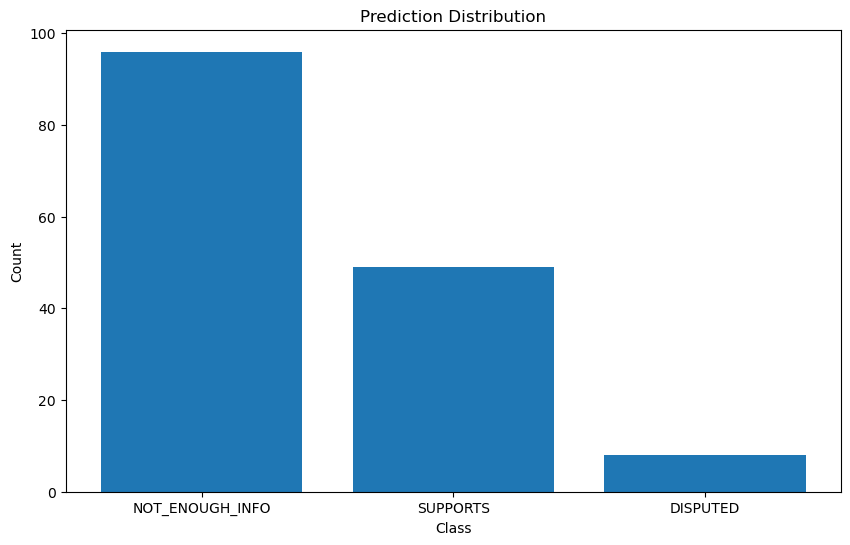


Results saved to classification_results.json


In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Define model to use
model_name = "distilbert-base-uncased"  # Use the model you've trained with

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create ensemble classifier
ensemble = EnsembleClassifier([model_name], device, num_labels=len(id2labels))

# Run homogeneous ensemble
print("Running Homogeneous Ensemble...")
predictions = ensemble.homogeneous_ensemble(
    test_dataloader,
    model_name=model_name,
    model_checkpoint="best_classification_model.pth",
    num_runs=3
)
predicted_labels = [id2labels[pred] for pred in predictions]

# Visualize results
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # If ground truth is available
    if 'ground_truth' in locals() and ground_truth:
        # Convert labels to IDs
        label2id = {v: k for k, v in id2labels.items()}
        gt_ids = [label2id[label] for label in ground_truth]

        # Calculate confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(gt_ids, predictions)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(id2labels.values()),
                   yticklabels=list(id2labels.values()))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Homogeneous Ensemble Confusion Matrix')
        plt.tight_layout()
        plt.savefig('homogeneous_confusion_matrix.png', dpi=300)
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(gt_ids, predictions, target_names=list(id2labels.values())))
    else:
        # Just show prediction distribution
        from collections import Counter
        print("\nPrediction Distribution:")
        print(Counter(predicted_labels))

        # Plot distribution
        plt.figure(figsize=(10, 6))
        counter = Counter(predicted_labels)
        plt.bar(counter.keys(), counter.values())
        plt.title('Prediction Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.savefig('prediction_distribution.png', dpi=300)
        plt.show()

except ImportError:
    print("Could not generate visualization (matplotlib or seaborn not available)")

# Create results dictionary
results = {}
for i, test_id in enumerate(test_ids):
    results[test_id] = {
        'claim_text': test_claims[test_id]['claim_text'],
        'claim_label': predicted_labels[i],
        'evidences': test_claims[test_id]['evidences']
    }

# Save results to file
with open('classification_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults saved to classification_results.json")

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*